# Analysis of DEA results - efficiency, slacks, peer relations

***
## Imports and data

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import numpy as np
import statsmodels.api as sm
import scipy.stats
from fill_and_map import map_inds_sdg, fill_econ, map_econ_sdg, fill_inds_trans
fpath = Path('data_raw/SDG-DEA_indicators_V5_20200708.xlsx')

In [7]:
# read income and efficiency data
ic_in = pd.read_csv(Path('data_raw/income_cats.csv'), index_col=0, header=None)
ef_in_io = pd.read_csv(Path('analysis_data/eff_io.csv'), index_col=0)
# ef_in_oo = pd.read_csv(Path('analysis_data/eff_oo.csv'), index_col=0)

# concat into one dataframe
effio = pd.concat((ic_in.loc[ef_in_io.index,:], ef_in_io), axis=1)
# effoo = pd.concat((ic_in.loc[ef_in_oo.index,:], ef_in_oo), axis=1)
effio.columns = ['income',*effio.columns[1:]]
# effoo.columns = ['income',*effoo.columns[1:]]
inc = effio['income'].unique()
inc = ['LIC', 'LMIC', 'UMIC', 'HIC']

In [62]:
# general plot data
cmap = np.divide([[140,107,177],
                 [199,233,180],
                 [158,188,218],
                 [65,182,196]],255)  

cmap = np.divide([[140,107,177],
                 [114,177,79],
                 [158,188,218],
                 [65,182,196]],255)     
nbins = 12


***
## Improvement targets/slacks

In [23]:
# read slacks
orient='io'
spath = Path('analysis_data/slacks_{0}.xlsx'.format(orient))
writer = pd.ExcelWriter(spath, engine='xlsxwriter')
slacks = pd.DataFrame(columns=range(1,18), index=effio.index.rename(None))
for s in range(1,18):
    slacks[s] = pd.read_excel(writer, sheet_name = 'sdg{0}'.format(s), index_col=0, usecols=[0,1])


In [146]:
sl3 = pd.read_excel(spath, sheet_name='sdg3', index_col=0)

In [27]:
slacks.to_csv('analysis_data/input_slacks.csv')

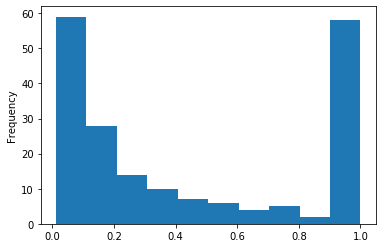

In [24]:
effio['sdg1'].plot.hist()

***
## Analysis of economic data
Things to add:
- income categories (categorical) vs. spend for each economic input
- same thing, but spend as percentage of GDP

In [17]:
econ = fill_econ(fpath)
map_econ = map_econ_sdg(fpath)
inds = fill_inds_trans(fpath)

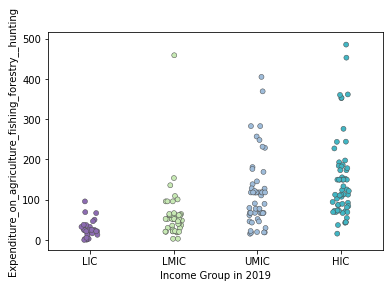

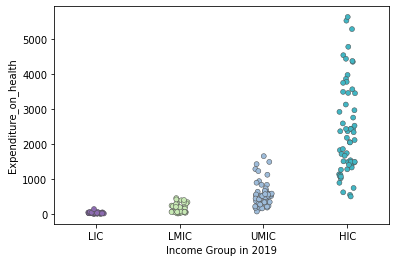

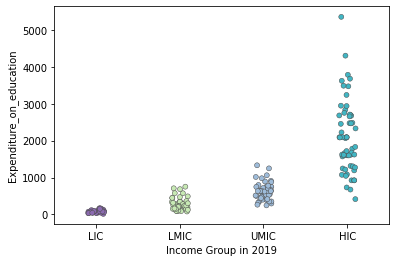

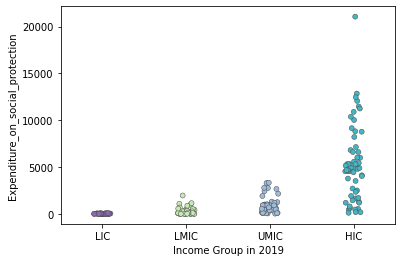

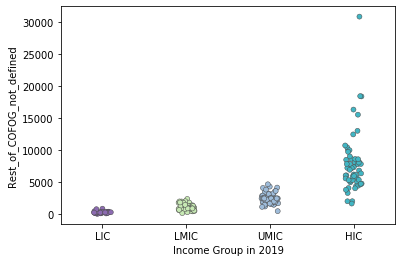

In [36]:
import seaborn as sns
for ii in range(1,6):
    fig, ax = plt.subplots(1, 1)
    ax = sns.stripplot(x=econ.columns[0], y=econ.columns[ii], data=econ, palette=cmap, linewidth=.5)

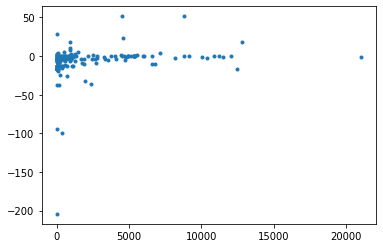

In [257]:
plt.scatter(econ['Expenditure_on_social_protection'],inds['sdg10_fsi7'], marker='.', mark)

In [66]:
for ii in econ.columns[1:]:
    print(ii, econ.loc[:,ii].sort_values()[:10])

Expenditure_on_agriculture_fishing_forestry__hunting MWI    0.376766
COD    1.021209
MDG    1.919638
GNB    2.452220
LBR    3.143710
BDI    3.148916
NGA    3.159543
SDN    3.322496
CAF    4.024145
SLE    5.833959
Name: Expenditure_on_agriculture_fishing_forestry__hunting, dtype: float64
Expenditure_on_health COD     5.426226
CAF     5.598660
NER    13.014719
BDI    13.707434
HTI    14.137400
TCD    14.223931
GMB    17.153876
GIN    17.465929
BGD    17.763416
UGA    17.932908
Name: Expenditure_on_health, dtype: float64
Expenditure_on_education COD    15.789776
TCD    35.431022
BDI    38.158755
LBR    38.684400
NER    42.686542
UGA    45.204557
HTI    49.135771
MWI    49.310943
GMB    52.163864
MDG    52.180982
Name: Expenditure_on_education, dtype: float64
Expenditure_on_social_protection BDI    1.523048
TCD    1.580437
BFA    1.859648
CAF    2.799330
STP    3.944693
PNG    4.233124
TZA    5.028488
HTI    5.301525
UGA    5.379872
LBR    5.988019
Name: Expenditure_on_social_protection, d

***
## Analysis of peer relationships

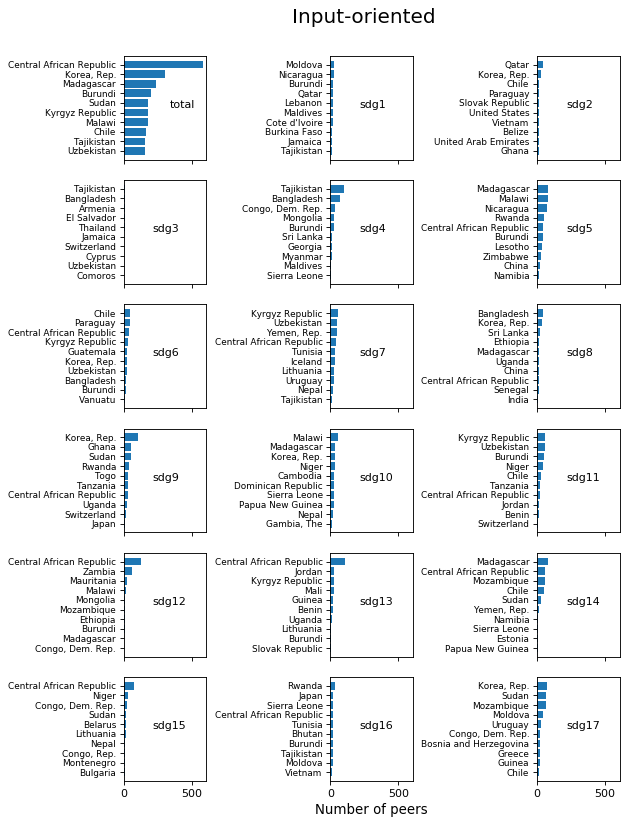

In [22]:
# # Peer analysis

# read peer excel file
orient = 'io'
cid = pd.read_csv('data_raw/country_id.csv', index_col=[1]) # country id to transform from three-letter iso code to name
cid = cid.loc[effio.index, :] # remove countries omitted in DEA
xls = pd.ExcelFile(Path('analysis_data/lambdas_{0}.xlsx'.format(orient))) # so we don't have to reload the file for each sheet
peer_data = {}
sdg_strings = ['sdg{0}'.format(ii) for ii in range(1,18)]
for s in sdg_strings:
    peer_data[s] = pd.read_excel(xls, s, index_col=[0])
    peer_data[s].columns = cid['c']
    peer_data[s].index = cid['c']

cutoff = 0.001 # so we don't consider very weak peer relationships
peer_counts = {}

# count number of times a country has acted as peer, minus "self-peering"
for s in sdg_strings:
    peer_counts[s] = peer_data[s][peer_data[s] > cutoff].count() - np.diag(peer_data[s])

# plot peer counts
nc = 10 # number of countries to display

y_pos = np.arange(nc)
fig, ax = plt.subplots(6, 3, figsize=(8, 12), dpi=80, facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(wspace=1.5)
ax = ax.ravel()

for jj, ax0 in enumerate(ax):
    sdg_n = sdg_strings[jj-1]
    if jj==0:
        plot_counts = sum(peer_counts.values()).sort_values()[-nc:]
        ax0.barh(y_pos, plot_counts)
        ax0.text(.55,.5,'total',transform=ax0.transAxes)
    else:
        plot_counts = peer_counts[sdg_n].sort_values()[-nc:]
        ax0.barh(y_pos, plot_counts)
        ax0.text(.35,.5,sdg_n,transform=ax0.transAxes)

    ax0.set_yticks(y_pos)
    ax0.set_yticklabels(plot_counts.index, fontsize=8)

# add a big axis, hide frame
ax3 = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax3.set_xlabel("Number of peers", fontsize=12)
# ax3.set_ylabel("Counts", fontsize=12)

if orient=='oo':
    fig.suptitle('Output-oriented', y=0.93, fontsize=18)
    plt.savefig('figures/peercount_all_oo.png', bbox_inches='tight', dpi=600)
elif orient=='io':
    fig.suptitle('Input-oriented', y=0.93, fontsize=18)
    plt.savefig('figures/peercount_all_io.png', bbox_inches='tight', dpi=600)



c
AFG           Afghanistan
AGO                Angola
ALB               Albania
ARE  United Arab Emirates
ARG             Argentina
..                    ...
VUT               Vanuatu
YEM           Yemen, Rep.
ZAF          South Africa
ZMB                Zambia
ZWE              Zimbabwe

[156 rows x 1 columns]

***
## Miscellaneous 
### Desired/undesired outputs

In [40]:
# number of desired/undesired outputs for each SDG
map_inds = map_inds_sdg(fpath)
use_inds_path = Path('data_raw/use_inds.xlsx')
use_inds = pd.read_excel(use_inds_path, usecols='A:D')
skip_inds = use_inds['ind_name'][use_inds['use']=='no']
undes_inds = use_inds['ind_name'][use_inds['issue']=='undesired']


for ii in map_inds:
    n_ind = len(set(map_inds[ii]) - set(skip_inds))
    n_undes = len(set(map_inds[ii]) & set(undes_inds) - set(skip_inds))
    n_des = n_ind - n_undes
    print('SDG {0}:'.format(ii),'{0} ({1}/{2})'.format(n_ind, n_des, n_undes))


SDG 1: 4 (4/0)
SDG 2: 8 (6/2)
SDG 3: 17 (15/2)
SDG 4: 3 (3/0)
SDG 5: 4 (4/0)
SDG 6: 5 (3/2)
SDG 7: 3 (3/0)
SDG 8: 6 (5/1)
SDG 9: 5 (5/0)
SDG 10: 8 (5/3)
SDG 11: 3 (3/0)
SDG 12: 6 (0/6)
SDG 13: 4 (2/2)
SDG 14: 4 (2/2)
SDG 15: 6 (4/2)
SDG 16: 8 (6/2)
SDG 17: 4 (3/1)


In [263]:
pi = Path('analysis_data/updated_sdg10/sdg10_eff_res_io.csv')
po = Path('analysis_data/updated_sdg10/sdg10_eff_res_oo.csv')
s10io = pd.read_csv(pi, sep='\t', index_col=[0])
s10oo = pd.read_csv(po, sep='\t', index_col=[0])

***
## Efficiency analysis

In [4]:
# read income and efficiency data
orient = 'io'
ic_in = pd.read_csv(Path('data_raw/income_cats.csv'), index_col=0, header=None)
ef_in = pd.read_csv(Path('analysis_data/eff_{0}.csv'.format(orient)), index_col=0)


# concat into one dataframe
eff = pd.concat((ic_in.loc[ef_in.index,:], ef_in), axis=1)
eff.columns = ['income',*eff.columns[1:]]
inc = eff['income'].unique()

effio = eff.copy()
# effoo = eff

In [78]:
# get number of efficient countries by income group
grouped = effio.groupby(by='income')
n_eff = pd.DataFrame(columns=effio.columns[1:], index=effio['income'].unique())
for ss in effio.columns[1:]:
    n_eff.loc[:, ss] = grouped[ss].apply(lambda x: sum(x==1))
n_eff = n_eff.reindex([''.join(('sdg',str(ii))) for ii in range(1,18)], axis=1)
n_eff.columns = [jj.upper() for jj in n_eff.columns]

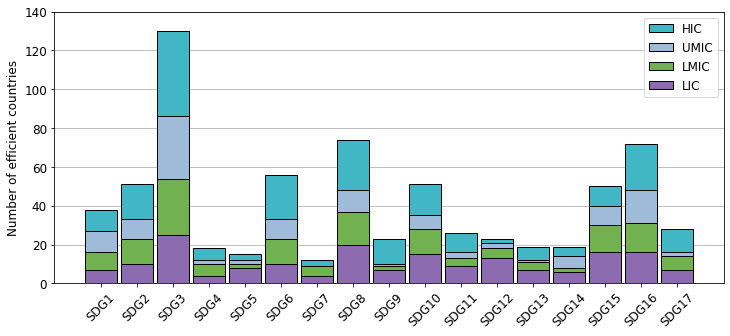

In [104]:
# stacked bar chart of efficient countries by income group
width = .9
labels = n_eff.columns
fig, ax = plt.subplots(figsize=(12,5))

ax.grid(axis='y')

bot = 0
for ii, inc in enumerate(n_eff.index):
    ax.bar(labels, n_eff.loc[inc, :], width, bottom=bot, label=inc, color=cmap[ii, :], edgecolor='k')
    bot += n_eff.loc[inc, :]

ax.set_axisbelow(True)
ax.set_ylim(ymax=140)
ax.set_ylabel('Number of efficient countries', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), fontsize=12)

# plt.savefig('figures/n_eff_countries.jpg', dpi=600)
# plt.savefig('figures/n_eff_countries.svg')

In [66]:
[(inc, ii) for inc, ii in enumerate(n_eff.index)]

[(0, 'LIC'), (1, 'LMIC'), (2, 'UMIC'), (3, 'HIC')]

Text(0.5, 0.21, 'Efficiency')

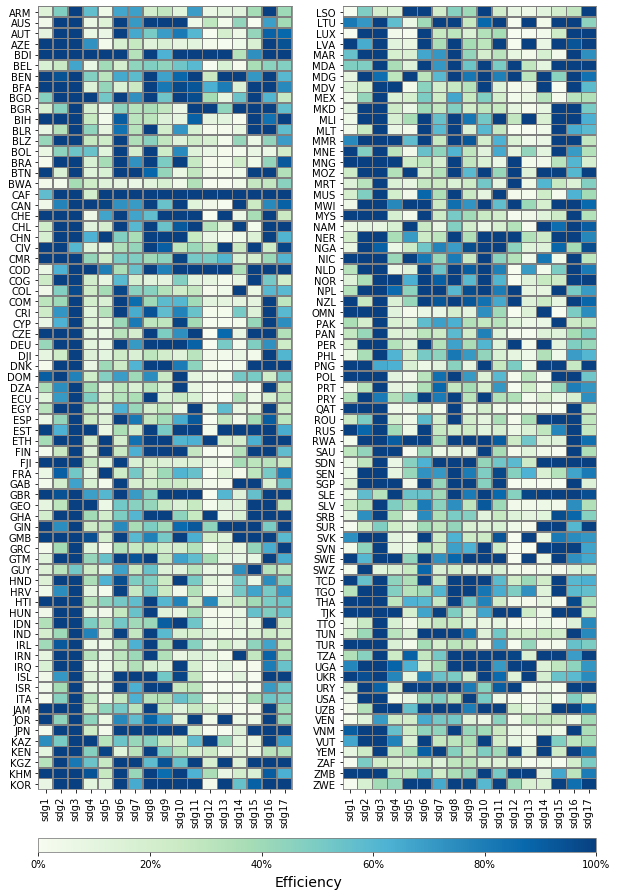

In [5]:
#  efficiency heatmap
import seaborn as sns

heat_eff = effio.iloc[:,1:]
fig, axes = plt.subplots(1, 2, figsize=(10, 18), gridspec_kw={'wspace':0.2})

for ii, ax in enumerate(axes):
    hm = sns.heatmap(np.array_split(heat_eff, 2)[ii], ax=ax, cmap='GnBu', cbar=False, vmin=0, vmax=1, linewidths=.5, linecolor='grey')

    # draw border around heatmap
    for _, spine in hm.spines.items():
        spine.set_visible(True)
        spine.set_color('grey')

# fix cutoff bug for first and last row
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.setp(axes, ylim=(b,5))

# custom colorbar
cnorm = matplotlib.colors.Normalize(vmin=0, vmax=1)
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=cnorm, cmap='GnBu'), ax=axes, orientation='horizontal', pad=0.05, aspect=40, drawedges=False)
cbar.outline.set_edgecolor('grey')
cbar.set_ticks(np.linspace(0,1,6))
cbar.set_ticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

plt.suptitle('Efficiency', y=0.21, fontsize=14)

# plt.savefig('figures/eff_heatmap.png', bbox_inches='tight', dpi=600)

In [64]:
for ii, ax in enumerate(axes):
    print(ii, ax)

0 AxesSubplot(0.125,0.125;0.352273x0.755)
1 AxesSubplot(0.547727,0.125;0.352273x0.755)


In [49]:
heat_eff.iloc[:int(heat_eff.shape[0]/2),:]

sdg1      sdg2      sdg3      sdg4      sdg5      sdg6      sdg7  \
AFG  0.037855  0.319224  1.000000  0.303141  0.143685  0.177619  0.439191   
AGO  0.054764  1.000000  0.525223  0.112332  0.096391  0.108128  0.171850   
ALB  0.157541  0.135671  1.000000  0.381648  0.054970  0.977615  0.479784   
ARE  1.000000  1.000000  1.000000  0.112783  0.045683  0.294105  0.067650   
ARG  0.204725  1.000000  1.000000  0.599822  0.105277  1.000000  0.279953   
..        ...       ...       ...       ...       ...       ...       ...   
KAZ  0.748509  0.505277  1.000000  1.000000  0.320478  0.540908  0.419627   
KEN  0.123241  1.000000  1.000000  0.471535  0.986697  0.117892  0.310425   
KGZ  1.000000  1.000000  0.817013  0.543895  0.269349  1.000000  1.000000   
KHM  1.000000  1.000000  1.000000  0.938767  0.271733  1.000000  0.421258   
KOR  0.169212  1.000000  1.000000  0.113549  0.136360  1.000000  0.648682   

         sdg8      sdg9     sdg10     sdg11     sdg12     sdg13     sdg14  \
AFG  0.145242  0.115264  0.435092  0.118579  0.154870  0.049221  0.049221   
AGO  0.140343  0.105682  0.473683  0.054885  0.094982  0.032975  0.115642   
ALB  0.242083  0.278526  0.066112  0.183995  0.023726  0.023726  0.245115   
ARE  1.000000  1.000000  0.375060  0.408494  0.002718  0.113229  0.067045   
ARG  1.000000  0.186150  1.000000  0.407561  0.146248  0.010335  0.341721   
..        ...       ...       ...       ...       ...       ...       ...   
KAZ  0.461097  0.281072  0.210514  0.574105  1.000000  0.415170  0.105039   
KEN  1.000000  0.494043  0.323397  0.176679  0.246532  0.055443  0.148711   
KGZ  0.578569  0.938670  0.557856  1.000000  0.188152  1.000000  0.150257   
KHM  1.000000  0.861618  1.000000  0.627134  0.366881  0.081528  0.207303   
KOR  1.000000  1.000000  1.000000  1.000000  0.025460  1.000000  0.554847   

        sdg15     sdg16     sdg17  
AFG  0.519575  0.194893  0.125721  
AGO  0.086067  0.115389  1.000000  
ALB  1.000000  0.600420  0.511215  
ARE  0.004781  1.000000  0.105943  
ARG  0.010335  0.228284  0.438714  
..        ...       ...       ...  
KAZ  0.083190  1.000000  0.690749  
KEN  0.055443  0.309300  0.337765  
KGZ  1.000000  1.000000  1.000000  
KHM  0.160352  0.907227  0.635606  
KOR  0.896732  1.000000  1.000000  

[78 rows x 17 columns]

In [50]:
heat_eff.iloc[int(heat_eff.shape[0]/2):,:]

sdg1      sdg2      sdg3      sdg4      sdg5      sdg6      sdg7  \
KWT  1.000000  0.424778  1.000000  0.099587  0.023241  0.301629  0.219150   
LAO  0.045950  1.000000  0.529695  0.358130  0.190688  1.000000  0.615154   
LBN  1.000000  0.429512  1.000000  0.457329  0.071854  0.275823  0.171209   
LBR  0.301920  1.000000  1.000000  0.408169  0.229322  0.880831  0.156177   
LKA  0.206946  1.000000  1.000000  1.000000  0.197266  0.607372  0.377053   
..        ...       ...       ...       ...       ...       ...       ...   
VUT  0.783894  1.000000  1.000000  0.782841  0.162210  1.000000  0.271038   
YEM  0.109080  0.243863  1.000000  0.280182  0.378621  0.901185  1.000000   
ZAF  0.054169  0.501521  0.220680  0.202930  0.139789  0.239646  0.136998   
ZMB  1.000000  1.000000  1.000000  0.302885  0.303309  0.509449  0.226407   
ZWE  0.112930  0.175885  0.387164  0.431955  1.000000  1.000000  0.655732   

         sdg8      sdg9     sdg10     sdg11     sdg12     sdg13     sdg14  \
KWT  0.215912  0.122157  0.029172  0.305029  0.014650  0.287511  0.027221   
LAO  1.000000  0.257196  0.290584  0.161678  0.167022  0.039136  0.075203   
LBN  0.495833  0.184546  0.085400  0.123261  0.025888  0.063779  0.019095   
LBR  1.000000  0.168687  1.000000  0.092842  1.000000  0.092842  1.000000   
LKA  1.000000  0.208046  0.114932  0.140240  0.154149  0.033040  0.154998   
..        ...       ...       ...       ...       ...       ...       ...   
VUT  0.304364  0.357407  1.000000  0.219228  0.089557  0.047072  1.000000   
YEM  0.471029  0.288951  0.485073  0.397436  1.000000  0.141029  1.000000   
ZAF  0.290608  0.307650  0.164105  0.148240  0.134114  0.011658  0.055617   
ZMB  0.362885  0.433038  1.000000  0.508171  1.000000  1.000000  0.121126   
ZWE  1.000000  0.991459  0.600563  1.000000  0.403480  0.168154  0.168154   

        sdg15     sdg16     sdg17  
KWT  0.004030  1.000000  1.000000  
LAO  1.000000  0.858407  0.363407  
LBN  0.012999  0.330004  0.289601  
LBR  0.131845  0.397200  0.256902  
LKA  0.033040  0.771268  0.202159  
..        ...       ...       ...  
VUT  0.481381  0.297235  0.385181  
YEM  0.231017  1.000000  0.796806  
ZAF  0.011658  0.207728  0.502863  
ZMB  0.661064  0.306387  0.803148  
ZWE  1.000000  0.849732  0.993081  

[78 rows x 17 columns]

In [30]:
effio

income      sdg1      sdg2      sdg3      sdg4      sdg5      sdg6  \
AFG    LIC  0.037855  0.319224  1.000000  0.303141  0.143685  0.177619   
AGO   LMIC  0.054764  1.000000  0.525223  0.112332  0.096391  0.108128   
ALB   UMIC  0.157541  0.135671  1.000000  0.381648  0.054970  0.977615   
ARE    HIC  1.000000  1.000000  1.000000  0.112783  0.045683  0.294105   
ARG    HIC  0.204725  1.000000  1.000000  0.599822  0.105277  1.000000   
..     ...       ...       ...       ...       ...       ...       ...   
VUT   LMIC  0.783894  1.000000  1.000000  0.782841  0.162210  1.000000   
YEM    LIC  0.109080  0.243863  1.000000  0.280182  0.378621  0.901185   
ZAF   UMIC  0.054169  0.501521  0.220680  0.202930  0.139789  0.239646   
ZMB   LMIC  1.000000  1.000000  1.000000  0.302885  0.303309  0.509449   
ZWE    LIC  0.112930  0.175885  0.387164  0.431955  1.000000  1.000000   

         sdg7      sdg8      sdg9     sdg10     sdg11     sdg12     sdg13  \
AFG  0.439191  0.145242  0.115264  0.435092  0.118579  0.154870  0.049221   
AGO  0.171850  0.140343  0.105682  0.473683  0.054885  0.094982  0.032975   
ALB  0.479784  0.242083  0.278526  0.066112  0.183995  0.023726  0.023726   
ARE  0.067650  1.000000  1.000000  0.375060  0.408494  0.002718  0.113229   
ARG  0.279953  1.000000  0.186150  1.000000  0.407561  0.146248  0.010335   
..        ...       ...       ...       ...       ...       ...       ...   
VUT  0.271038  0.304364  0.357407  1.000000  0.219228  0.089557  0.047072   
YEM  1.000000  0.471029  0.288951  0.485073  0.397436  1.000000  0.141029   
ZAF  0.136998  0.290608  0.307650  0.164105  0.148240  0.134114  0.011658   
ZMB  0.226407  0.362885  0.433038  1.000000  0.508171  1.000000  1.000000   
ZWE  0.655732  1.000000  0.991459  0.600563  1.000000  0.403480  0.168154   

        sdg14     sdg15     sdg16     sdg17  
AFG  0.049221  0.519575  0.194893  0.125721  
AGO  0.115642  0.086067  0.115389  1.000000  
ALB  0.245115  1.000000  0.600420  0.511215  
ARE  0.067045  0.004781  1.000000  0.105943  
ARG  0.341721  0.010335  0.228284  0.438714  
..        ...       ...       ...       ...  
VUT  1.000000  0.481381  0.297235  0.385181  
YEM  1.000000  0.231017  1.000000  0.796806  
ZAF  0.055617  0.011658  0.207728  0.502863  
ZMB  0.121126  0.661064  0.306387  0.803148  
ZWE  0.168154  1.000000  0.849732  0.993081  

[156 rows x 18 columns]

### Single SDG

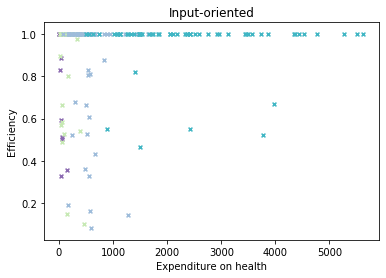

In [161]:
fig, ax = plt.subplots(1,1)
for ii,inc in enumerate(eff['income'].unique()):
    csel = effio.index[eff['income']==inc]
    ax.scatter(econ.loc[csel]['Expenditure_on_health'], effio.loc[csel]['sdg3'], s=15, c=cmap[ii,:].reshape(1,-1), marker='x')

ax.set_title('Input-oriented');
ax.set_xlabel('Expenditure on health');
ax.set_ylabel('Efficiency');

In [362]:
print('Proportion of countries with efficient health spending')
for ii in ['LIC','LMIC','UMIC','HIC']:
    ninc = effio['sdg3'][effio['income']==ii].shape[0]
    neff = sum(effio['sdg3'][effio['income']==ii]==1)
    print(ii, '\t', str(neff),'/',str(ninc), '\t', str(int(100*round(neff/ninc,2))), '%')

Proportion of countries with efficient health spending
LIC 	 27 / 34 	 79 %
LMIC 	 34 / 45 	 76 %
UMIC 	 39 / 55 	 71 %
HIC 	 53 / 59 	 90 %


In [235]:
# load peer data
peer_data = pd.read_excel(Path('analysis_data/lambdas_{0}.xlsx'.format(orient)), 'sdg3', index_col=[0])
for cc in peer_data.columns: # remove "self-peering" of efficient countries
    peer_data.loc[cc,cc] = 0

In [535]:
cutoff = 0.01
nc = 14 # number of countries to display

# count number of times a country has acted as peer to countries within each income category
peer_counts = pd.DataFrame(columns=effio['income'].unique(), index=effio.index.rename(None))
for ii in peer_counts.columns:
    cinc = effio.index[eff_io['income']==ii]
    peer_counts[ii] = peer_data.loc[cinc,:][peer_data.loc[cinc,:] > cutoff].count()
peer_counts['total'] = peer_counts.sum(axis=1)
peer_counts['income'] = effio['income']
# plot_counts = peer_counts.sort_values(by=['total'], ascending=False)[:14]

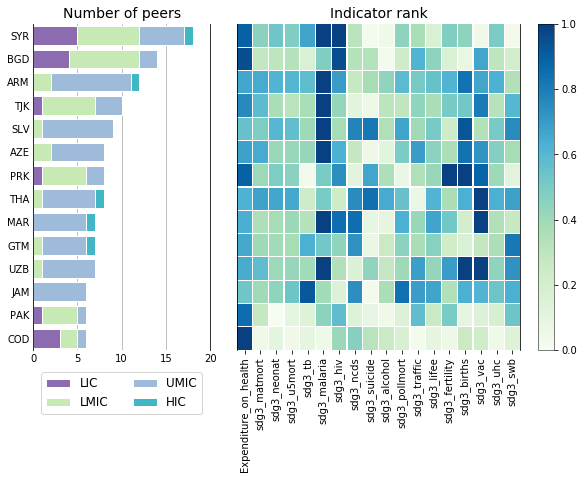

In [590]:
# Number of peers as horizontal bar chart, stacked by income category

import matplotlib.patheffects as path_effects
plotdata = peer_counts.sort_values(by=['total'], ascending=False)[:nc].iloc[:,:4].copy() # nc countries acting as peers most often
inc_col = {inc:cmap[ii,:] for ii,inc in enumerate(plotdata.columns)} # colours for each income category

fig, (ax,ax2) = plt.subplots(1, 2, figsize=(10,6), gridspec_kw={'width_ratios': [1, 2], 'wspace':0.1})
ax.invert_yaxis()
for ii, inc in enumerate(plotdata.columns):
    width = plotdata[inc]
    labels = plotdata.index
    starts = plotdata.iloc[:,:ii].sum(axis=1)
    ax.barh(labels, width, left=starts, color=cmap[ii,:], edgecolor='w', linewidth=1, zorder=2, label=inc)
ax.set_xlim(xmin=0, xmax=20)
ax.grid(axis='x', zorder=0)
ax.legend(ncol=int(len(plotdata.columns)/2), bbox_to_anchor=(0.5, -.05),loc='upper center', fontsize='large');
ax.set_yticks(np.arange(nc))
ax.set_ylim(ax.get_ylim()[0]+.5, ax.get_ylim()[1]-.5)
ax.tick_params(axis='both', which='both',length=0)
ax.set_title('Number of peers', fontsize='14')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# indicator ranks/percentiles

cols3 = [ii for ii in inds.columns if ii.startswith('sdg3')]
heat_inds = inds[cols3].rank(pct=True, method='max', axis=0).loc[plotdata.index,:]
heat_econ = econ[['Expenditure_on_health']].rank(pct=True, method='max', axis=0, ascending=False).loc[plotdata.index,:]
heatdata = pd.concat([heat_econ, heat_inds], axis=1)

sns.heatmap(heatdata, cmap='GnBu', linewidths=.1, ax=ax2, cbar_kws={})

# fix cutoff bug for first and last row
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)

ax2.spines['left'].set_visible(True)
ax2.spines['right'].set_visible(True)
# ax2.spines['top'].set_visible(True)
# ax2.spines['bottom'].set_visible(True)

ax2.set_title('Indicator rank', fontsize='14');
ax2.tick_params(left=False, labelleft=False) 

cbar = ax2.collections[0].colorbar
cbar.set_ticks(np.linspace(heatdata.min().min(),1,6))
cbar.set_ticklabels(['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
cbar.outline.set_edgecolor('k')
cbar.outline.set_linewidth(.5)

# plt.savefig('figures/peers_ind_rank.png', bbox_inches='tight', dpi=300)

# # change colour of country names
# for ytick in ax.get_yticklabels():
#     print(ytick, ' ', ytick.get_text(), ' ', peer_counts.loc[ytick.get_text(),'income'], ' ', inc_col[peer_counts.loc[ytick.get_text(),'income']])
#     ytick.set_color(inc_col[peer_counts.loc[ytick.get_text(),'income']])
#     ytick.set_path_effects([path_effects.Stroke(linewidth=.3, foreground='dimgrey'),path_effects.Normal()])

In [15]:
cols3 = [ii for ii in inds.columns if ii.startswith('sdg3')]
heat_inds = inds[cols3].rank(pct=True, method='max', axis=0).loc[plotdata.index,:]
heat_econ = econ[['Expenditure_on_health']].rank(pct=True, method='max', axis=0, ascending=False).loc[plotdata.index,:]
heatdata = pd.concat([heat_econ, heat_inds], axis=1)

sns.set_palette('green')
sns.heatmap(heatdata, linewidths=.1)

# fix cutoff bug for first and last row
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

NameError: name 'inds' is not defined

### Countries with most 100% efficiency scores

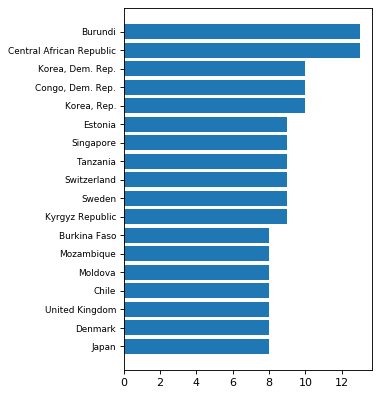

In [354]:
# which countries are most often efficient

nc = 18 # number of countries to display
freq_eff = eff[eff==1].sum(axis=1).sort_values(ascending=True)[-nc:]
freq_eff.index = [cid.loc[ii,'c'] for ii in freq_eff.index] # change country code to full name

y_pos = np.arange(nc)

fig, ax = plt.subplots(1, 1, figsize=(4, 6), dpi=80, facecolor='w', edgecolor='k')
ax.barh(y_pos, freq_eff)
ax.set_yticks(y_pos)
ax.set_yticklabels(freq_eff.index, fontsize=8);


### Boxplots, beanplots, etc.

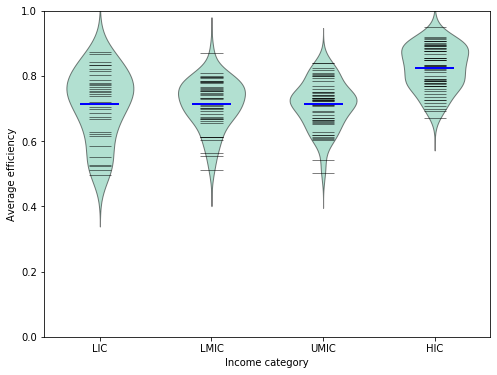

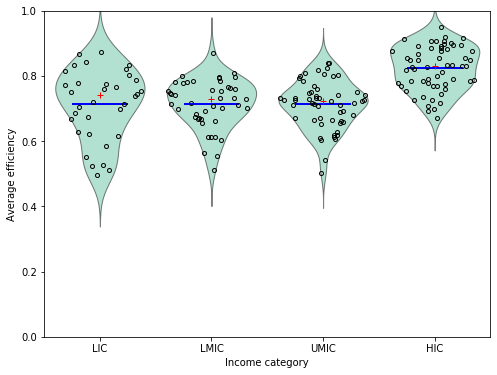

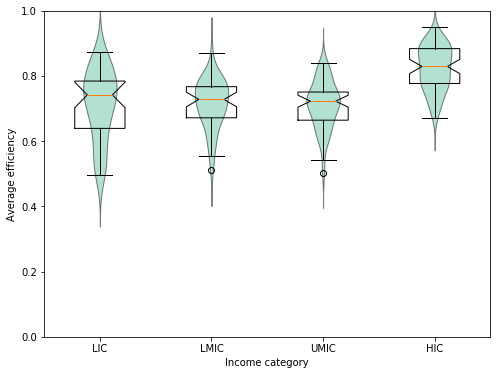

In [279]:
# beanplots - single

data = [eff[eff['income']==ii].mean(axis=1) for ii in inc]
def bean(data, labels, plot_opts={}, jitter=False):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    plot_opts_ = {}
    #              {'cutoff_val':5, 'cutoff_type':'abs',
    #             'label_fontsize':'small',
    #             'label_rotation':30}

    plot_opts_.update(plot_opts)
    sm.graphics.beanplot(data, ax=ax, labels=labels,
                         jitter=jitter, plot_opts=plot_opts_, side='both')
    ax.set_xlabel("Income category")
    ax.set_ylabel("Average efficiency")
    ax.set_ylim(0,1)

def violin(data, labels):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    plot_opts={'violin_width':.3}
    sm.graphics.violinplot(data, ax=ax, labels=labels, plot_opts=plot_opts)
    ax.set_xlabel("Income category")
    ax.set_ylabel("Average efficiency")    
    ax.set_ylim(0,1)

# fig = bean([eff[cc] for cc in eff.columns[1:]], labels=eff.columns[1:])
fig = bean(data, labels=inc, plot_opts={'violin_width':.6, 'bean_size':.2, 'bean_show_median':False, 'bean_mean_size':.35})
fig = bean(data, labels=inc, jitter=True)
fig = violin(data, labels=inc)

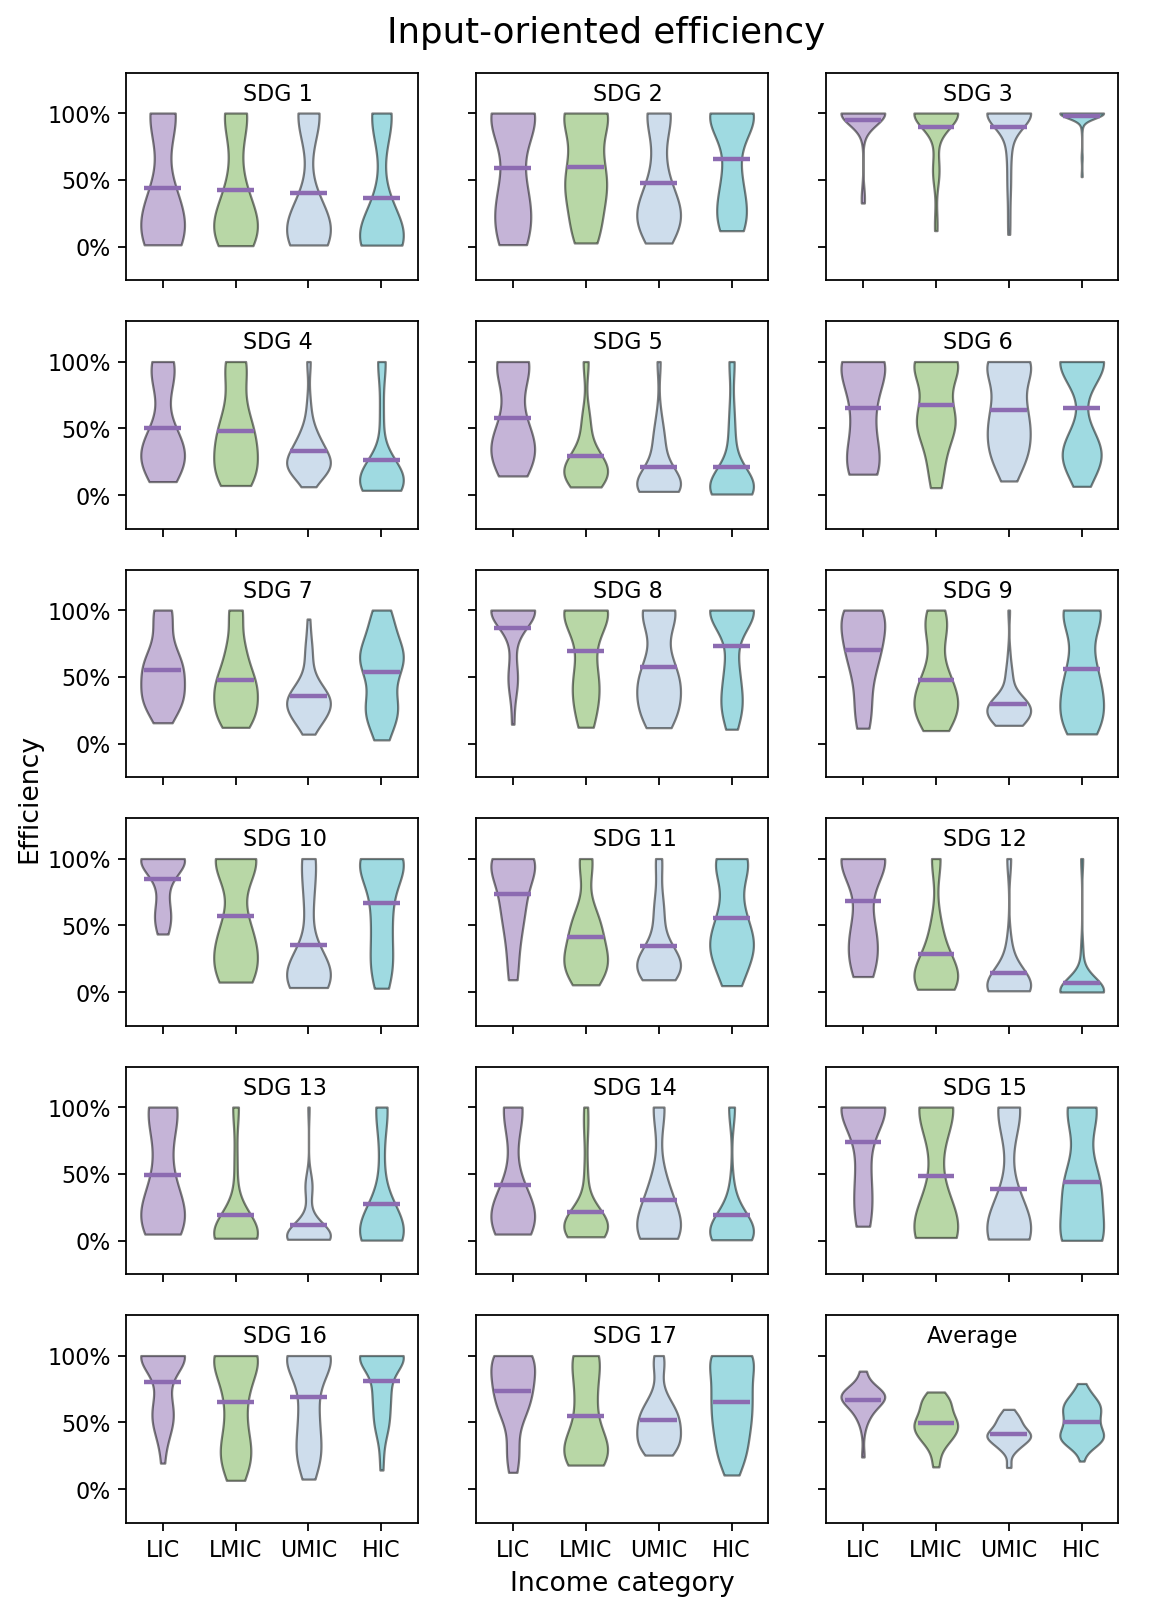

In [128]:
# beanplots - 6x3 grid
orient = 'Input'
if orient == 'Input':
    eff = effio
elif orient == 'Output':
    eff = effoo


def bean(data, labels, ax, plot_opts={}, jitter=False):
    plot_opts_ = {}
    #              {'cutoff_val':5, 'cutoff_type':'abs',
    #             'label_fontsize':'small',
    #             'label_rotation':30}
    plot_opts_.update(plot_opts)
    bp = sm.graphics.beanplot(data, ax=ax, labels=labels,
                         jitter=jitter, plot_opts=plot_opts_, side='both')
    return(bp)


fig, ax = plt.subplots(6,3, figsize=(8, 12), dpi=80, facecolor='w', edgecolor='k', sharex=True, sharey=True)
ax = ax.ravel()
for jj,ax0 in enumerate(ax):
    if jj == 17:
        data = [eff[eff['income']==ii].mean(axis=1) for ii in inc]
        ax0.text(.5,.87,'Average',transform=ax0.transAxes, ha='center')
    else:
        sdg_n = ''.join(('sdg',str(jj+1)))
        data = [eff[sdg_n][eff['income']==ii] for ii in inc]
        ax0.text(.4,.87,''.join(('SDG ',str(jj+1))),transform=ax0.transAxes)

    for ii, dd in enumerate(data): # handle cases where one income category has zero standard deviation

        if data[ii].shape[0] == 1: 
            data[ii] = data[ii].repeat(2) # add "extra" country if only one country in income category
        if data[ii].std() == 0: 
            data[ii].iloc[0] *= 0.999 # perturb first value to avoid singular matrix for kde estimation

    ax0.set_ylim(-.25,1.3)
    ax0.set_yticklabels(('','0%','50%','100%'))

    # add a big axis, hide frame
    ax3 = fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    ax3.set_xlabel("Income category", fontsize=12)
    ax3.set_ylabel("Efficiency", fontsize=12, labelpad=15)
    fig.suptitle('{0}-oriented efficiency'.format(orient), y=0.91, fontsize=16)

    # only violin and mean, no data
    bp = bean(data, inc, ax0, plot_opts={'violin_width':.6, 'bean_size':0, 'bean_show_median':False, 
                                    'bean_show_mean':True, 'bean_mean_size':.5, 'violin_fc':cmap[2,:], 
                                    'bean_mean_color':cmap[0,:], 'cutoff':True})

# modify violin colours [VERY helpful: matplotlib.artist.getp(fig)]
# for art in fig.get_children()[1:-2]: # 18 children for each subplot
#     for ii, art2 in enumerate(art.get_children()[0::3][:4]): # get the 4 PolyCollections for the violins
#         art2.set_facecolor(cmap[ii,:]) # set colours

,# plt.savefig('figures/violin_mean_io_col.jpg', bbox_inches='tight', dpi=600)

In [132]:
# effio[['income', 'sdg1']].to_csv('../../../Downloads/eff1.csv')

In [131]:
effio.groupby(by='income').mean()

sdg10     sdg11     sdg12     sdg13     sdg14     sdg15     sdg16  \
income                                                                         
HIC     0.668113  0.551794  0.069720  0.275999  0.189390  0.436610  0.810251   
LIC     0.847979  0.735993  0.684374  0.493610  0.417778  0.738631  0.805480   
LMIC    0.568532  0.415152  0.287087  0.191115  0.216429  0.482521  0.653768   
UMIC    0.355772  0.344251  0.144992  0.116179  0.307065  0.384445  0.692069   

           sdg17      sdg1      sdg2      sdg3      sdg4      sdg5      sdg6  \
income                                                                         
HIC     0.650599  0.362720  0.653607  0.980537  0.263050  0.211903  0.649149   
LIC     0.734363  0.441483  0.587193  0.948864  0.502626  0.580847  0.648532   
LMIC    0.550144  0.424307  0.598259  0.894311  0.476605  0.293908  0.677338   
UMIC    0.517287  0.399113  0.476527  0.896078  0.332343  0.208780  0.639911   

            sdg7      sdg8      sdg9  
income                                
HIC     0.537864  0.732115  0.557658  
LIC     0.553814  0.865406  0.700843  
LMIC    0.478086  0.695144  0.479186  
UMIC    0.356636  0.577066  0.299888

### Histograms

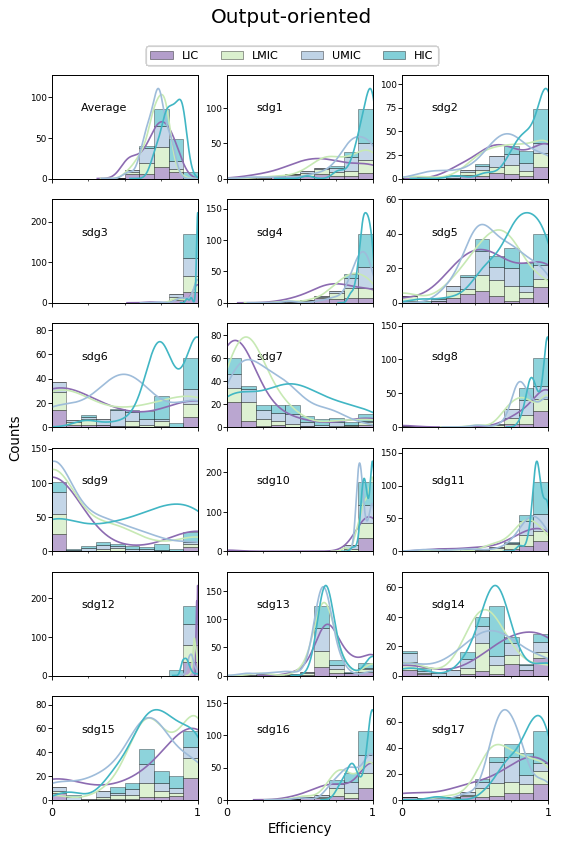

In [36]:
# stacked hist & KDE in one, every and all SDGs

aa = 0.6

def make_hist_kde(fig,ax):
    maxy2_mult = 1.15
    maxy1_mult = 1.5

    for jj,ax0 in enumerate(ax):
        ax00 = ax0.twinx()
        if jj == 0:
            histdata = [eff[eff['income']==ii].mean(axis=1) for ii in inc]
            ax0.text(.2,.65,'Average',transform=ax0.transAxes)
            pos1 = ax0.get_position()
        else:
            sdg_n = ''.join(('sdg',str(jj)))
            histdata = [eff[sdg_n][eff['income']==ii] for ii in inc]
            ax0.text(.2,.65,sdg_n,transform=ax0.transAxes)

        ybins, xbins, _ = ax0.hist(histdata, bins=np.linspace(0, 1, num=11), stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2, alpha=aa)
        pd.concat(histdata, axis=1).plot.kde(color=cmap, ax = ax00, legend=False, alpha=1)
        ax0.set_xlim(0,1)

        # automatically adjust ylim for both axes
        maxy_hist = maxy1_mult*np.stack(ybins).max()
        ax0.set_ylim(0,maxy_hist)
        maxy_kde = maxy2_mult*max([ll.get_ydata().max() for ll in ax00.lines])
        ax00.set_ylim(0,maxy_kde)

        ax00.yaxis.set_visible(False)
        ax0.set_xticks([0,1])
        ax0.set_xticklabels([0,1])
        ax0.tick_params(axis='y', which='major', labelsize=8, pad=1)

        handles, labels = ax0.get_legend_handles_labels()
        leg = fig.legend(handles, labels, loc='center', bbox_to_anchor=[0.5,0.9], ncol=4, bbox_transform=fig.transFigure)



fig, ax = plt.subplots(6,3, figsize=(8, 12), dpi=80, facecolor='w', edgecolor='k', sharex=True)
ax = ax.ravel()
make_hist_kde(fig,ax)

# add a big axis, hide frame
ax3 = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax3.set_xlabel("Efficiency", fontsize=12)
ax3.set_ylabel("Counts", fontsize=12)


fig.suptitle('Input-oriented', y=0.95, fontsize=18)
# plt.savefig('figures/stackedhist2_kde_all_io.png', bbox_inches='tight', dpi=600)

if orient=='oo':
    fig.suptitle('Output-oriented', y=0.95, fontsize=18)
elif orient=='io':
    fig.suptitle('Input-oriented', y=0.95, fontsize=18)

plt.savefig('figures/kde_hist_{0}.png'.format(orient), bbox_inches='tight', dpi=600)



In [26]:
# histogram of average efficies across SDGs, stacked by income category

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
plt.hist([eff[eff['income']==ii].iloc[:,1:].mean(axis=1) for ii in inc], bins = nbins, stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2)

plt.xlabel('Average efficiency')
plt.ylabel('Number of countries')
plt.legend()

# reverse legend order
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], ['High income', 'Upper middle income', 'Lower middle income', 'Low income'])

NameError: name 'nbins' is not defined

(0, 4)

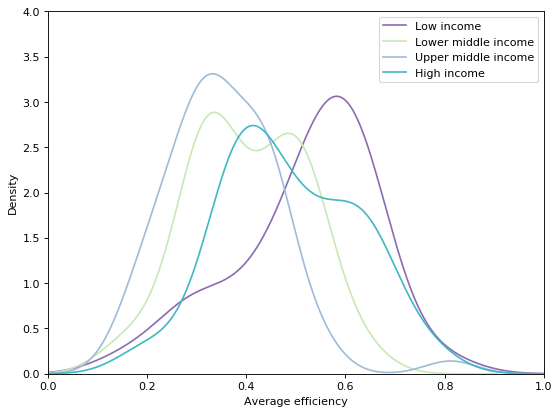

In [14]:
# KDE plot of average efficiencies across SDGs, for each income category

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

av_eff = [eff[eff['income']==ii].mean(axis=1) for ii in inc]

ax = pd.concat(av_eff, axis=1).plot.kde(color=cmap, ax = plt.gca())
plt.xlabel('Average efficiency')
plt.ylabel('Density')
plt.legend(['High income', 'Upper middle income', 'Lower middle income', 'Low income'][::-1])
# plt.axes([0,1.2,0,4])
ax.set_xlim(0,1)
ax.set_ylim(0,4)

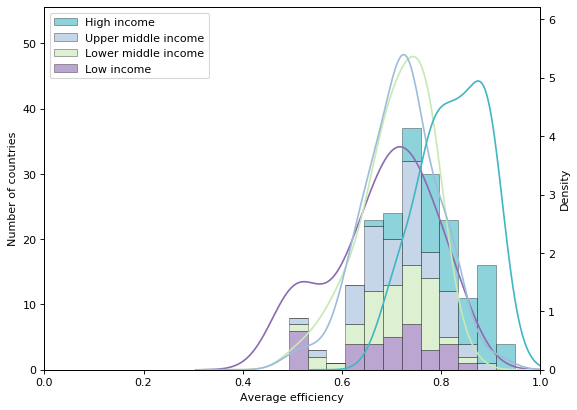

In [315]:
# stacked hist & KDE, in same plot
maxy2_mult = 1.15
maxy1_mult = 1.5

fig, ax = plt.subplots(1,1, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax2 = ax.twinx()

histdata = [eff[eff['income']==ii].mean(axis=1) for ii in inc]
ybins, xbins, _ = ax.hist(histdata, bins = nbins, stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2, alpha=.6)

pd.concat(histdata, axis=1).plot.kde(color=cmap, ax = ax2, legend=False, alpha=1)
ax.set_xlim(0,1)

# automatically adjust ylim for both axes
maxy_hist = maxy1_mult*np.stack(ybins).max()
ax.set_ylim(0,maxy_hist)
maxy_kde = maxy2_mult*max([ll.get_ydata().max() for ll in ax2.lines])
ax2.set_ylim(0,maxy_kde)

ax.set_ylabel('Number of countries')
# ax.set_xlabel('Average efficiency')
ax.set_xlabel('Average efficiency')
# ax.set_ylabel('Estimated density')

# legend in correct order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], ['High income', 'Upper middle income', 'Lower middle income', 'Low income'], loc=2)

***
***
## old not-so-good ideas below

Text(0.5, 1.0, 'Input-oriented')

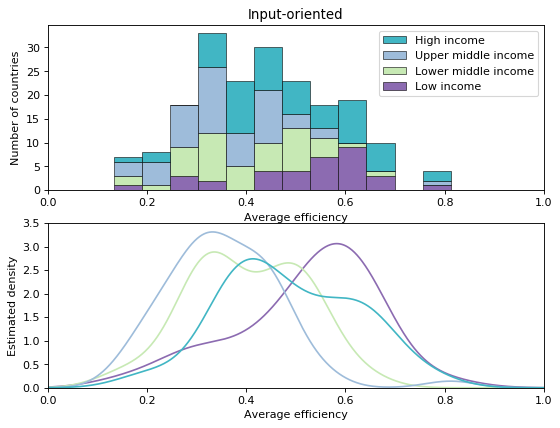

In [58]:
# stacked hist & KDE, in subplots

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 6), dpi=80, sharex=False, facecolor='w', edgecolor='k')
ax1.hist([eff[eff['income']==ii].iloc[:,1:].mean(axis=1) for ii in inc], bins = nbins, stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2)
av_eff = [eff[eff['income']==ii].mean(axis=1) for ii in inc]
pd.concat(av_eff, axis=1).plot.kde(color=cmap, ax = ax2, legend=False)
ax1.set_xlim(0,1)
ax2.set_xlim(0,1)
ax2.set_ylim(0,3.5)
ax1.set_ylabel('Number of countries')
ax1.set_xlabel('Average efficiency')
ax2.set_xlabel('Average efficiency')
ax2.set_ylabel('Estimated density')

# legend in correct order
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], ['High income', 'Upper middle income', 'Lower middle income', 'Low income'])

ax1.set_title('Input-oriented')

# plt.savefig('figures/stackedhist_kde_io.png', bbox_inches='tight', dpi=600)


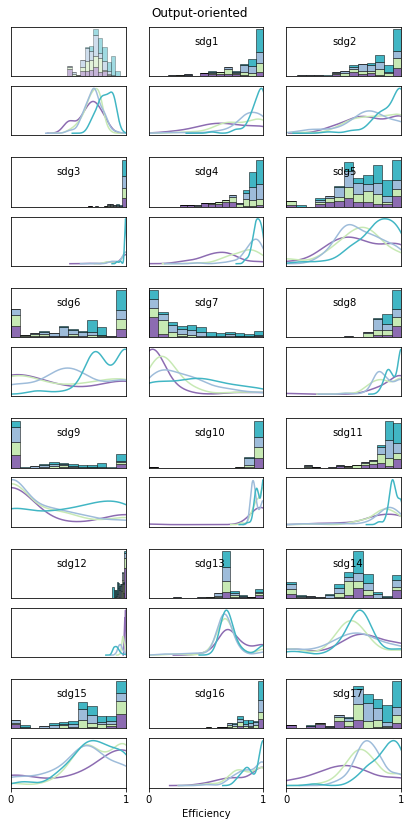

In [178]:
# stacked hist & KDE as subplots, every and all SDGs

def format_subplots(ax0,ax1):
    ax0.set_xlim(0,1)
    ax1.set_xlim(0,1)
    # ax0.set_ylim(0,100)
    # ax1.set_ylim(0,100)
    ax0.get_yaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax0.get_xaxis().set_visible(False)
    
def allsdg_hist_kde(fig):
    a = 1
    ax0 = fig.axes[0]
    ax1 = fig.axes[1]
    ax0.hist([eff[eff['income']==ii].iloc[:,1:].mean(axis=1) for ii in inc], bins = nbins, stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2)
    av_eff = [eff[eff['income']==ii].mean(axis=1) for ii in inc]
    pd.concat(av_eff, axis=1).plot.kde(color=cmap, ax=ax1, legend=False)
    format_subplots(ax0,ax1)
    ax1.get_xaxis().set_visible(False)
    ax0.set_ylabel('Histogram')
    ax1.set_ylabel('Density')

def onesdg_hist_kde(fig):
    for jj, (ax0,ax1) in enumerate(zip(fig.axes[2::2], fig.axes[3::2])):
        sdg_n = ''.join(('sdg',str(jj+1)))
        ax0.hist([eff[sdg_n][eff['income']==ii] for ii in inc], bins = nbins, stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2)
        single_eff = [eff[sdg_n][eff['income']==ii] for ii in inc]
        pd.concat(single_eff, axis=1).plot.kde(color=cmap, ax=ax1, legend=False)
        format_subplots(ax0,ax1)
        ax0.text(.4,.65,sdg_n,transform=ax0.transAxes)
        if jj>=14:
            ax1.set_xticks([0,1])
            ax1.set_xticklabels([0,1])
            if jj == 15:
                ax1.set_xlabel('Efficiency')
        else:
            ax1.get_xaxis().set_visible(False)


f = plt.figure()
gs0 = gridspec.GridSpec(6, 3, figure=f)
for ii in range(18):
    gs01 = gs0[ii].subgridspec(2,1)
    f.add_subplot(gs01[0])
    f.add_subplot(gs01[1])

allsdg_hist_kde(f)
onesdg_hist_kde(f)
f.suptitle('Output-oriented', y=0.9)
f.set_size_inches([7,14])

# plt.savefig('figures/stackedhist_kde_all_oo.png', bbox_inches='tight', dpi=600)

In [ ]:
# if ax.is_last_row():
#     ax.spines['bottom'].set_visible(True)
# if ax.is_first_col():